# DM-27853 Plot cutouts of goodDiaObjects from the CI HSC/COSMOS-PDR2 dataset

This notebook looks at a Gen3 Butler repo created by running ap_verify --gen3 on the aforementioned dataset. It collects the visits with good seeing (for some definition of good), and plots cutouts of the good diaObjects in the calexp, difference image, and warped difference images. At the end it will optionally display sources on the processed image(s).

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import functools
import operator
from IPython.display import IFrame
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
import lsst.geom
afwDisplay.setDefaultBackend("matplotlib")
from lsst.ap.association import UnpackApdbFlags, MapDiaSourceConfig


In [2]:
sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla

The oringal input repo (/project/kherner/notebooks_DM-27853/ap_verify_run) is an ap_verify run of the CI/HSC COSMOS-PDR2 dataset.

In [3]:
basedir = '/project/kherner/notebooks_DM-27853/ap_verify_run'
myrepo  = basedir + '/repo'
butler  = dafButler.Butler(myrepo)

We still have to manaually generate the visit lists; hopefully that will change in the future.

In [4]:
visits_HSC_G_g = [59150, 59160]
visit_ccd = {}
visit_band = {}
# declare these as lists because we will in general have multple CCDs
visit_ccd[59150] = [ 50 ]
visit_ccd[59160] = [ 51 ]
visit_band[59150] = "g"
visit_band[59160] = "g"

Compute the PSFs and store them in a dict. Later, we'll use them to cut on sources with bad seeing.

In [5]:
psf_HSC_G_g_dict = {}
sigma2fwhm = 2.*np.sqrt(2.*np.log(2.))
for visit in visits_HSC_G_g:
    mydataId = {"instrument":"HSC", "visit":visit,
                "detector":visit_ccd[visit][0],"band":visit_band[visit]}
    psf = butler.get("calexp", component="psf",
                     collections=["ap_verify-output"],
                     dataId=mydataId).getPsf()
    fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm

    psf_HSC_G_g_dict[visit] = fwhm

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/obs_base/21.0.0-36-gf6c110f+50b5aac5e4/python/lsst/obs/base/formatters/fitsExposure.py:489: UserWarning: Data ID {instrument: 'HSC', detector: 50, visit: 59150} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/obs_base/21.0.0-36-gf6c110f+50b5aac5e4/python/lsst/obs/base/formatters/fitsExposure.py:489: UserWarning: Data ID {instrument: 'HSC', detector: 51, visit: 59160} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for

Make a seeing cut at 2x the bext seeing. Build a separate list of visits passing the cut.

In [6]:
threshold = min(psf_HSC_G_g_dict.values())*2.
visits_HSC_G_g_goodSeeing = []
for visit, fwhm in psf_HSC_G_g_dict.items():
    if fwhm <= threshold:
        visits_HSC_G_g_goodSeeing.append(visit)
print(visits_HSC_G_g_goodSeeing)

[59150, 59160]


Get the pixel scale as arcseconds in case we need it

In [7]:
pixelScale = butler.get("calexp",collections=["ap_verify-output"], 
                    dataId={"instrument":"HSC", "visit":visits_HSC_G_g[0],
                    "detector":visit_ccd[visits_HSC_G_g[0]][0],
                    "band": visit_band[visits_HSC_G_g[0]]}).getWcs().getPixelScale().asArcseconds()
print(pixelScale)

0.16859809499284403


Let's create a list of additional filters we want to use to reject bad DIASources

In [8]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_offimage',
               'base_PixelFlags_flag_edge',
               'ip_diffim_forced_PsfFlux_flag_noGoodPixels']

Create good DIAObject and DIASource tables using the loadTable command. We can create additional lists of good sources and/or objects using our 
own bad flag list defined above, if we want more flags than the defaults (only the first three).
Then we use goodSrc2 and goodObj2 later on.

In [9]:
objTable, srcTable, goodObj, goodSrc = pla.loadTables(myrepo,isVerify=True,instrument='HSC',gen='gen3')
objTable2, srcTable2, goodObj2, goodSrc2 = pla.loadTables(myrepo,isVerify=True,instrument='HSC',
                                                    gen='gen3',badFlagList=badFlagList)

Make a plotting function so we don't type this all the time.

For each source we plot a cutout of the calexp (processed visit), the difference image itself, and the warped difference image.

In [10]:
def sourceplot(calimg, diffimg, warpimg, objid):
    myfig, (ax1,ax2,ax3) = plt.subplots(1,3)
    myfig.suptitle('diaObjectId: {}'.format(str(objid)), y=0.8)
    ax1.set_title('calexp')
    ax2.set_title('differenceExp')
    ax3.set_title('warped diff')
    ax1.imshow(calimg, cmap='gray')
    ax2.imshow(diffimg,cmap='gray')
    ax3.imshow(warpimg,cmap='gray')
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()

Plot the flux of all good sources for the chosen flux type, set a requirement on how close a source's flux has to be to the overall median source flux to get plotted.

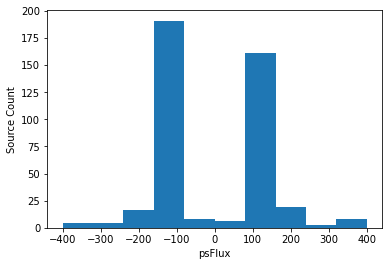

In [11]:
fluxType = 'psFlux'
fluxErr = fluxType + 'Err'
fluxplt, ax = plt.subplots()
bins = [-500, -400, -300, -200, -100, -50, 0, 50, 100, 200, 300, 400, 500]
ax.hist(goodSrc2[fluxType], range=(-400, 400))
ax.set_xlabel(fluxType)
ax.set_ylabel('Source Count')
fluxmedian = goodSrc2[fluxType].median()
fluxdev = np.std(goodSrc2[fluxType])
# require flux to be within Ndev s.d. of the median flux for good sources
Ndev = 1 

The above plot shows the flux of all good diaSources.

### Now we get to the meat. Loop over the good objects, applying the good seeing and flux s.d. requirements before plotting. Plotting only a subset for now (every 40th) just to keep it reasonable.

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/obs_base/21.0.0-36-gf6c110f+50b5aac5e4/python/lsst/obs/base/formatters/fitsExposure.py:489: UserWarning: Data ID {instrument: 'HSC', detector: 50, visit: 59150} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/obs_base/21.0.0-36-gf6c110f+50b5aac5e4/python/lsst/obs/base/formatters/fitsExposure.py:489: UserWarning: Data ID {instrument: 'HSC', detector: 50, visit: 59150} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for

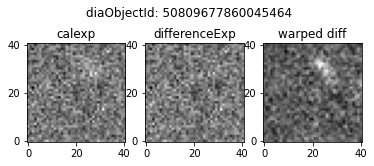

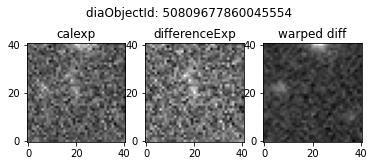

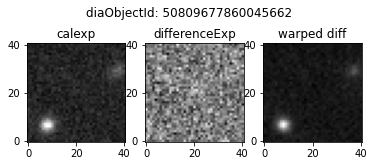

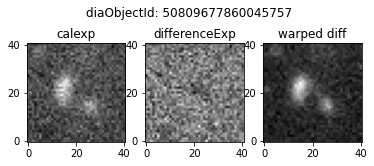

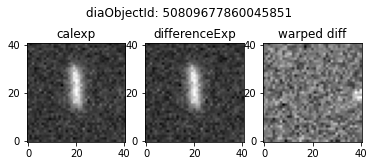

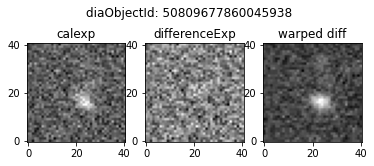

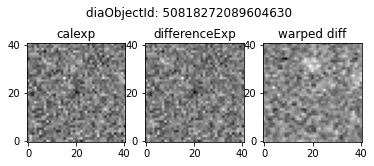

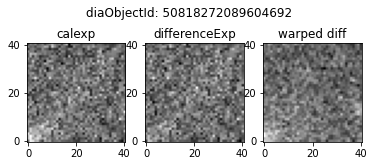

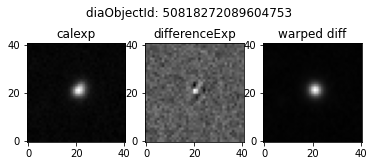

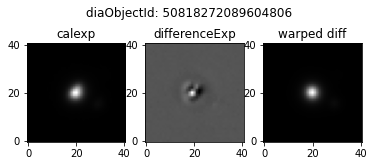

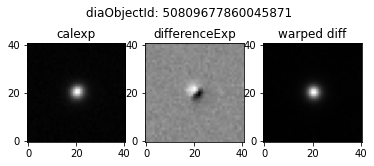

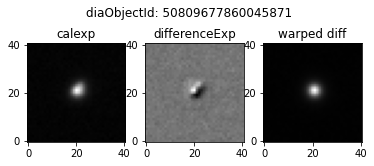

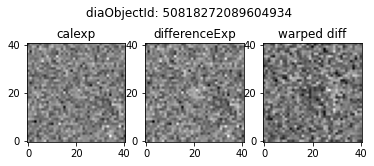

In [12]:
for iobj in range(0, len(goodObj2), 40):  
    objread = goodObj2.iloc[iobj]
    boxradius=20
    srcmatch = goodSrc2.loc[goodSrc2['diaObjectId'] == objread['diaObjectId'],
                            ['visit','filterName','ccd','ra','decl','x','y',fluxType,fluxErr]]
    
    if len(srcmatch) == 0:
        print("{} has no good source match? Might want to check on that."
              .format(objread['diaObjectId']))
        
    """    
    Loop over sources with a matching diaObjectID. For the CI HSC 
    COSMOSdataset there will usually only be one, but that will not
    be true in general.
    """
    
    for isrc in range(len(srcmatch)):
        # check this is a "good seeing" visit.
        if srcmatch['visit'].values[isrc] not in visits_HSC_G_g_goodSeeing:
            print('This visit did not meet seeing thresholds.')
            continue
        # only plot cutout if flux is within Ndev s.d. of median flux
        if abs(srcmatch[fluxType].values[isrc] - fluxmedian)/fluxdev > Ndev :
            print('Flux > {} s.d.: {} {} {}. Will not plot.'.format(Ndev, 
                srcmatch[fluxType].values[isrc], fluxmedian, fluxdev))
            continue

        mysphere = lsst.geom.SpherePoint(objread['ra'],
                                         objread['decl'], 
                                         units=lsst.geom.degrees)
        wcsget = butler.get("calexp",collections=["ap_verify-output"],
                            dataId={"instrument":"HSC",
                                    "visit":srcmatch['visit'].values[isrc],
                                    "detector":srcmatch['ccd'].values[isrc],
                                    "band":srcmatch['filterName'].values[isrc]}).getWcs()
        coords = wcsget.skyToPixel(mysphere)
        box3 = lsst.geom.Box2I(lsst.geom.Point2I(max(0,coords[0]-boxradius),
                                                 max(0,coords[1]-boxradius)), 
                               lsst.geom.Point2I(min(2047,coords[0]+boxradius), 
                                                 min(4175,coords[1]+boxradius)))
        calexp3 = butler.get("calexp", collections=["ap_verify-output"],
                             parameters={'bbox':box3},
                             band=srcmatch['filterName'].values[isrc],
                             dataId={"instrument":"HSC",
                                     "visit":srcmatch['visit'].values[isrc],
                                     "detector":srcmatch['ccd'].values[isrc]})
        diffimg = butler.get("deepDiff_differenceExp",
                             collections=["ap_verify-output"],
                             parameters={'bbox':box3},
                             dataId={"instrument":"HSC",
                                     "visit":srcmatch['visit'].values[isrc],
                                     "detector":srcmatch['ccd'].values[isrc]})
        warped = butler.get("deepDiff_warpedExp", 
                            collections=["ap_verify-output"],
                            parameters={'bbox':box3},
                            dataId={"instrument":"HSC",
                                    "visit":srcmatch['visit'].values[isrc],
                                    "detector":srcmatch['ccd'].values[isrc]})
        diffimgarr = diffimg.image.array
        calexp3arr = calexp3.image.array
        warparr    = warped.image.array
        sourceplot(calexp3arr, diffimgarr, warparr, objread['diaObjectId'])

### Now plot the diaSources on the images using Firefly so that we see the whole image.

In [13]:
afwDisplay.setDefaultBackend('firefly')
display1 = afwDisplay.Display(frame=1, name='DM-27853-1')
IFrame(display1._url, 1000, 1200)
display2 = afwDisplay.Display(frame=2, name='DM-27853-2')
IFrame(display2._url, 1000, 1200)

Note that if you view the notebook on Github, the Firefly display may not show up as output properly. 
It will work fine once it's actully run, however.

In [14]:
exptest = butler.get("deepDiff_differenceExp",
                     collections=["ap_verify-output"],
                     dataId={"instrument":"HSC",
                        "visit":visits_HSC_G_g_goodSeeing[0],
                        "band":visit_band[visits_HSC_G_g_goodSeeing[0]],
                        "detector":visit_ccd[visits_HSC_G_g_goodSeeing[0]][0]})
exptest2 = butler.get("deepDiff_differenceExp",
                     collections=["ap_verify-output"],
                     dataId={"instrument":"HSC",
                        "visit":visits_HSC_G_g_goodSeeing[1],
                        "band":visit_band[visits_HSC_G_g_goodSeeing[1]],
                        "detector":visit_ccd[visits_HSC_G_g_goodSeeing[1]][0]})
display1.mtv(exptest)
display2.mtv(exptest2)
src = goodSrc2.loc[goodSrc2['visit'] == visits_HSC_G_g_goodSeeing[0]]
src2 = goodSrc2.loc[goodSrc2['visit'] == visits_HSC_G_g_goodSeeing[1]]

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/obs_base/21.0.0-36-gf6c110f+50b5aac5e4/python/lsst/obs/base/formatters/fitsExposure.py:489: UserWarning: Data ID {instrument: 'HSC', detector: 50, visit: 59150} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/obs_base/21.0.0-36-gf6c110f+50b5aac5e4/python/lsst/obs/base/formatters/fitsExposure.py:489: UserWarning: Data ID {instrument: 'HSC', detector: 51, visit: 59160} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for

### Just for fun, pick one diaObject and single it out with a different color. I intentionally chose one that's in both images.

In [15]:
myObjId = 50809677860045871
with display1.Buffering(), display2.Buffering():
    for record in range(len(src)):
        display1.dot('o', src.iloc[record]['x'], src.iloc[record]['y'], 
                     size=20, ctype='orange')
    myxy = [src.loc[src['diaObjectId'] == myObjId], ['x', 'y']]
    if myxy[0].empty:
        print("{} is not in {}.".format(myObjId,visits_HSC_G_g_goodSeeing[0]))
    else:
        display1.dot('o',myxy[0]['x'], myxy[0]['y'], size=20,ctype='red')
        
    for record in range(len(src2)):
        display2.dot('o', src2.iloc[record]['x'], src2.iloc[record]['y'], 
                     size=20, ctype='orange')
    myxy = [src2.loc[src2['diaObjectId'] == myObjId],['x','y']]
    if myxy[0].empty:
        print("{} is not in {}.".format(myObjId,visits_HSC_G_g_goodSeeing[1]))
    else:
        display2.dot('o',myxy[0]['x'], myxy[0]['y'], size=20,ctype='red')

In [16]:
# cleanup
plt.close()